In [1]:
from bs4 import BeautifulSoup # For HTML parsing
import urllib2 # Website connections
import re # Regular expressions
from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of our term counts
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords # Filter out stopwords, such as 'the', 'or', 'and'
import pandas as pd # For converting results to a dataframe and bar chart plots
%matplotlib inline
from multiprocessing import Pool

### Create website content cleaning function to isolate non stop words for key word counting

### Cleaning for the raw html is necessary to get the final terms we are looking for. Extract the relevant portions of the html, get the text, removes blank lines and line endings, removes unicode, and filters with regular expressions to include only words

In [2]:
def text_cleaner(website):
    '''
    This function just cleans up the raw html so that I can look at it.
    Inputs: a URL to investigate
    Outputs: Cleaned text only
    '''
    
    try:
        site = urllib2.urlopen(website).read() # Connect to the job posting
    except: 
        return   # Need this in case the website isn't there anymore or some other weird connection problem 
    soup_obj = BeautifulSoup(site, "lxml") # Get the html from the site
    for script in soup_obj(["script", "style"]):
        script.extract() # Remove these two elements from the BS4 object
        text = soup_obj.get_text() # Get the text from this
        lines = (line.strip() for line in text.splitlines()) # break into lines
        chunks = (phrase.strip() for line in lines for phrase in line.split("  ")) # break multi-headlines into a line each
    def chunk_space(chunk):
        chunk_out = chunk + ' ' # Need to fix spacing issue
        return chunk_out  
    text = ''.join(chunk_space(chunk) for chunk in chunks if chunk).encode('utf-8') # Get rid of all blank lines and ends 
    #of line
    # Now clean out all of the unicode junk (this line works great!!!)
    try:
        text = text.decode('unicode_escape').encode('ascii', 'ignore') # Need this as some websites aren't formatted
    except:                                                            # in a way that this works, can occasionally throw
        return                                                         # an exception
    text = re.sub("[^a-zA-Z.+3]"," ", text)  # Now get rid of any terms that aren't words (include 3 for d3.js)
    # Also include + for C++
    text = text.lower().split()  # Go to lower case and split them apart
    stop_words = set(stopwords.words("english")) # Filter out any stop words
    text = [w for w in text if not w in stop_words]
    text = list(set(text)) # Last, just get the set of these. Ignore counts (we are just looking at whether a term existed
    # or not on the website)
    
    return text
    

### Function for specified city, state and job title indeed website URL list development 

In [3]:
def city_state(city = None, state = None):
    ''' This function accepts the desired city and state for Indeed search and returns the
    web site url. multi word cities are accoodated for like Salt Lake City'''
    final_job = 'data+scientist'
    # searching for data scientist exact fit("data scientist" on Indeed search)
    # Make sure the city specified works properly if it has more than one word(such as San Francisco)
    if city is not None:
        final_city = city.split()
        final_city = '+'.join(word for word in final_city)
        final_site_list = ['http://www.indeed.de/jobs?q=%22', final_job, '%22&l=', final_city,'%2C+', state]
        # Join all of our strings together so that indeed will search correctly
    else:
        final_site_list = ['http://www.indeed.de/jobs?q="', final_job, '"']
    
    final_site = ''.join(final_site_list) # Merge the html address together into one string
    print final_site
    return final_site

### Function 

In [4]:
def number_jobs(final_site,city):
    base_url = 'http://www.indeed.de'

    try:
        html = urllib2.urlopen(final_site).read() # Open up the front page of our search first
    except:
        'That city/state combination did not have any jobs. Exiting . . .' # In case the city is invalid
        return
    
    soup = BeautifulSoup(html, "lxml") # Get the html from the first page
    # Now find out how many jobs there were
    num_jobs_area = soup.find(id = 'searchCount').string.encode('utf-8')    # Now extract the total number of jobs found
                                                                            # The 'searchCount' object has this
    job_numbers = re.findall('\d+', num_jobs_area) # Extract the total jobs found from the search result
    print job_numbers[1]
    
    if len(job_numbers) > 3:
        #Have a total number of jobs greater than 1000
        total_num_jobs = (int(job_numbers[1]) * 1000) + int(job_numbers[2])
    else:
        total_num_jobs = int(job_numbers[1])
        
    
    city_title = city
    if city is None:
        city_title = 'Nationwide'
    
    print 'There were', total_num_jobs, 'jobs found,', city_title  # Display how many jobs were found
    num_pages = total_num_jobs / 10   # This will be how we know the number of times we need to iterate 
#    print num_pages, "pages"                                  # over each new search result page
    return num_pages

In [5]:
def get_description(job_URLS):
    
    job_descriptions = []
    final_description = []
    pool = Pool(15)
    job_descriptions = pool.map(text_cleaner, job_URLS)
    print final_description

    pool.close() 
    pool.join()
  #  for j in xrange(0, len(job_URLS)):
  #       print len(job_URLS)-j,
  #      final_description = text_cleaner(job_URLS[j])
  #      if final_description: #So that we only append when the website was accessed correctly
  #          job_descriptions.append(final_description)
#        sleep(1)# So that we don't be jerks. If you have a very fast internet connection you could hit the server a lot! 

    return job_descriptions
 

In [6]:
def find_jobs(num_pages, final_site):
    job_descriptions = []             # Store all our descriptions in this list
    job_URLS = []
    base_url = 'http://www.indeed.de'
    print 'Getting page',
    for i in xrange(1, num_pages + 1): #Loop through all of our search result pages
        print i,
        start_num = str(i * 10)       # Assign the multiplier of 10 to view the pages we want
        current_page = ''.join([final_site, '&start=', start_num])
       
        # Now that we can view the correct 10 job returns, start collecting the text samples from each
        html_page = urllib2.urlopen(current_page).read() # Get the page        
        page_obj = BeautifulSoup(html_page, "lxml")      # Locate all of the job links

        job_link_area = page_obj.find(id = 'resultsCol') # The center column on the page where the job postings exist
        for link in job_link_area.find_all('a'):
            if link.get('href') != None:                
                job_URLS.append(base_url + link.get('href'))

                #job_URLS = [base_url + link.get('href') for link in job_link_area.find_all('a')]
                # Get the URLS for the jobs
        job_URLS = filter(lambda x: 'clk' in x, job_URLS) # Now get just the job related URLS

    return job_URLS    
 

In [7]:
def skills_info(city = None, state = None):
    '''
    This function will take a desired city / state and look
    for all new job postings on Indeed.com. It will crawl all of the job postings and keep track of how many
    use a preset list of typical data science skills. The final percentage
    for each skill is then displayed at the end of the collation.
    Inputs: The location 's city and state. These are optional. If no city/state is input, 
    the function will assume a national search(this can take a while !!!).
    Input the city / state as strings, such as skills_info('Chicago', 'IL').
    Use a two letter abbreviation for the state.
    Output: A bar chart showing the most commonly desired skills in the job market for
    a data scientist.
    '''

    #final_site = city_state(city, state)
    sample = city_state(city,state)
    
    sample_no = number_jobs(sample,city)
    
    
    sample_jobs = find_jobs(sample_no,sample)
    
               
    job_descript = get_description(sample_jobs)
    
    print 'Done with collecting the job postings!'
    print 'There were', len(job_descript), 'jobs successfully found.'
    
    city_title = city
    doc_frequency = Counter()  # This will create a full counter of our terms.
    [doc_frequency.update(item) for item in job_descript]  # List comp
    # Now we can just look at our final dict list inside doc_frequency

    # Obtain our key terms and store them in a dict. 
    # These are the key data science skills we are looking for
    prog_lang_dict = Counter({
        'R': doc_frequency['r'],
        'Python': doc_frequency['python'],
        'Java': doc_frequency['java'],
        'C++': doc_frequency['c++'],
        'Ruby': doc_frequency['ruby'],
        'Perl': doc_frequency['perl'],
        'Matlab': doc_frequency['matlab'],
        'JavaScript': doc_frequency['javascript'],
        'Scala': doc_frequency['scala']
    })
    analysis_tool_dict = Counter({
        'Excel': doc_frequency['excel'],
        'Tableau': doc_frequency['tableau'],
        'D3.js': doc_frequency['d3.js'],
        'SAS': doc_frequency['sas'],
        'SPSS': doc_frequency['spss'],
        'D3': doc_frequency['d3']
    })
    hadoop_dict = Counter({
        'Hadoop': doc_frequency['hadoop'],
        'MapReduce': doc_frequency['mapreduce'],
        'Spark': doc_frequency['spark'],
        'Pig': doc_frequency['pig'],
        'Hive': doc_frequency['hive'],
        'Shark': doc_frequency['shark'],
        'Oozie': doc_frequency['oozie'],
        'ZooKeeper': doc_frequency['zookeeper'],
        'Flume': doc_frequency['flume'],
        'Mahout': doc_frequency['mahout']
    })
    database_dict = Counter({
        'SQL': doc_frequency['sql'],
        'NoSQL': doc_frequency['nosql'],
        'HBase': doc_frequency['hbase'],
        'Cassandra': doc_frequency['cassandra'],
        'MongoDB': doc_frequency['mongodb'],
        'mining':doc_frequency['mining'],
        'scraping' :doc_frequency['scraping'],
        'phd' :doc_frequency['phd']
    })
    overall_total_skills = prog_lang_dict + analysis_tool_dict + hadoop_dict + database_dict
    # Combine our Counter objects
    print overall_total_skills
    final_frame = pd.DataFrame(overall_total_skills.items(), columns = ['Term', 'NumPostings'])
    # Convert these terms to a dataframe
    # Change the values to reflect a percentage of the postings
    final_frame.NumPostings = (final_frame.NumPostings) * 100 / len(job_descript)
    # Gives percentage of job postings# having that term
    # Sort the data for plotting purposes
    #final_frame.sort(key=takeSecond, reverse=True)  # Get it ready for a bar plot
    final_frame.sort_values('NumPostings', ascending = False, inplace = True)
    
    final_plot = final_frame.plot(x = 'Term', kind = 'bar', legend = None, title = 'Percentage of Data Scientist Job Ads with a Key Skill, ' + city_title)
    final_plot.set_ylabel('Percentage Appearing in Job Ads')
    fig = final_plot.get_figure()     # Have to convert the pandas plot object to a matplotlib object
    return fig, final_frame  # End of the function

http://www.indeed.de/jobs?q=%22data+scientist%22&l=berlin%2C+
182
There were 182 jobs found, berlin
Getting page 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 []
Done with collecting the job postings!
There were 165 jobs successfully found.
Counter({'Python': 119, 'R': 63, 'SQL': 56, 'mining': 39, 'Spark': 29, 'phd': 20, 'Java': 18, 'Scala': 16, 'Hadoop': 16, 'Tableau': 10, 'JavaScript': 8, 'NoSQL': 7, 'Excel': 7, 'SPSS': 7, 'SAS': 7, 'Hive': 6, 'Matlab': 5, 'C++': 4, 'MongoDB': 4, 'D3.js': 2, 'Perl': 1, 'D3': 1})
24.4320008755


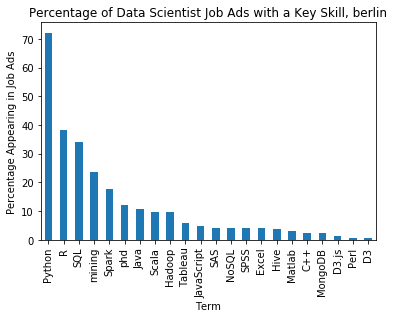

In [8]:
from timeit import default_timer as timer

start = timer()

seattle_info = skills_info(city = 'berlin', state = '') 
seattle_info

end = timer()
print(end - start)